# February 2021 Cablevision Mexico

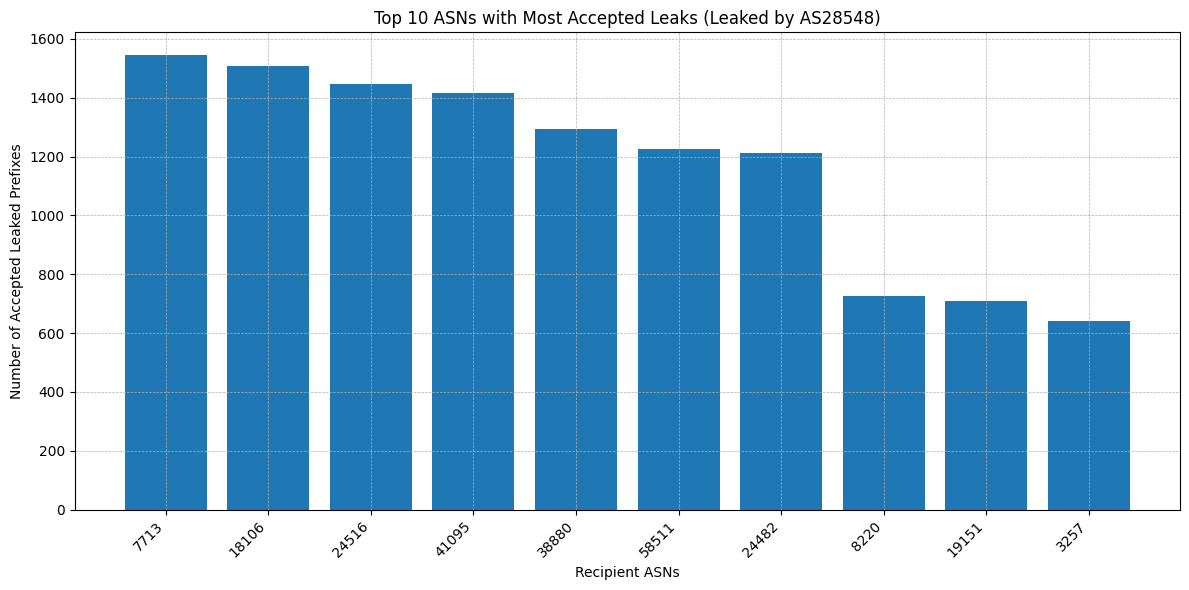

In [8]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-02-11 00:00:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Target ASN and the ASN through which leaks propagated
leaking_asn = "28548"

# Initialize BGPStream with an expanded list of collectors
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views.sg", "route-views.eqix"],
    record_type="updates"
)

# Store counts of leaked prefixes and recipient ASNs
leaked_prefixes = defaultdict(set)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            as_path = elem.fields["as-path"].split()
            prefix = elem.fields["prefix"]
            if leaking_asn in as_path:
                # Record recipient ASN and the prefix
                recipient_asn = as_path[0]
                leaked_prefixes[recipient_asn].add(prefix)

# Count the number of unique prefixes accepted by each recipient ASN
prefix_count_per_asn = {asn: len(prefixes) for asn, prefixes in leaked_prefixes.items()}

# Sort ASNs by the number of accepted prefixes
sorted_asns = sorted(prefix_count_per_asn.items(), key=lambda x: x[1], reverse=True)[:10]  # Top 10 ASNs

# Extracting ASNs and their counts for plotting
asns, counts = zip(*sorted_asns)

# Visualizing the top 10 ASNs
plt.figure(figsize=(12, 6))
plt.bar(asns, counts)
plt.xlabel('Recipient ASNs')
plt.ylabel('Number of Accepted Leaked Prefixes')
plt.title(f'Top 10 ASNs with Most Accepted Leaks (Leaked by AS{leaking_asn})')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

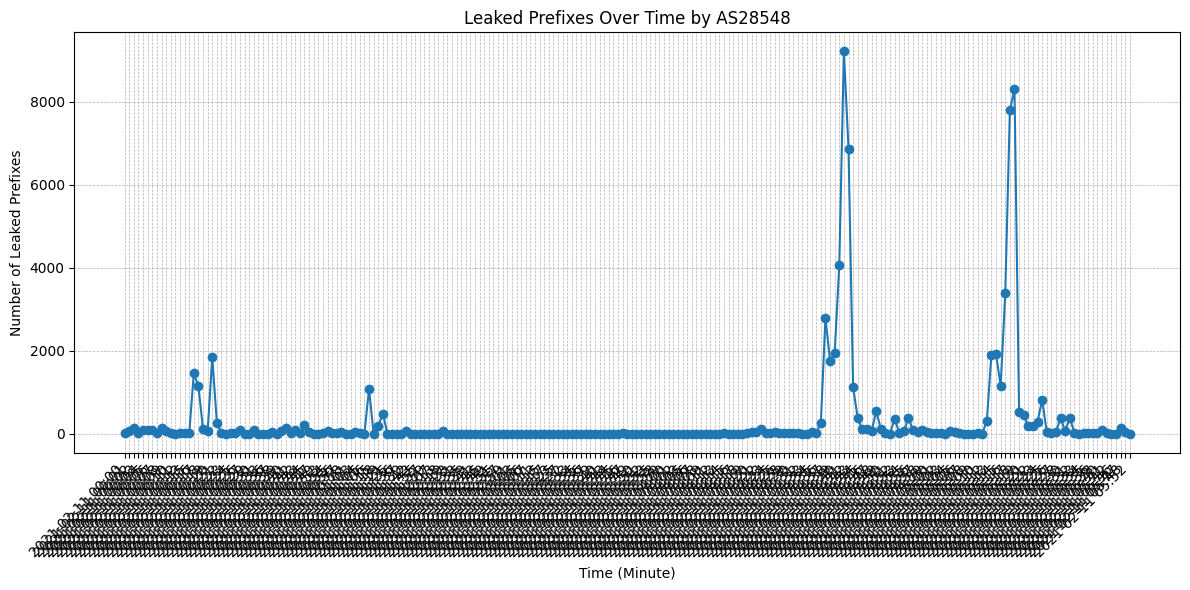

In [2]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-02-11 00:00:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Target ASN that propagated the leaks
leaking_asn = "28548"

# Initialize BGPStream with an expanded list of collectors
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["route-views.sg", "route-views.eqix"],
    record_type="updates"
)

# Store counts of leaked prefixes over time
leaked_prefixes_over_time = defaultdict(int)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            as_path = elem.fields["as-path"].split()
            prefix = elem.fields["prefix"]
            if leaking_asn in as_path:
                timestamp_minute = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
                leaked_prefixes_over_time[timestamp_minute] += 1

# Visualizing the spike in leaked prefixes over time
timestamps = sorted(leaked_prefixes_over_time.keys())
counts = [leaked_prefixes_over_time[ts] for ts in timestamps]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker='o', linestyle='-')
plt.xlabel('Time (Minute)')
plt.ylabel('Number of Leaked Prefixes')
plt.title(f'Leaked Prefixes Over Time by AS{leaking_asn}')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

1701392986 HTTP ERROR: Failure when receiving data from the peer (56)
1701392986 HTTP ERROR: Failure when receiving data from the peer (56)
2023-12-01 10:09:46 189997: bs_transport_file.c:39: ERROR: Could not open http://data.ris.ripe.net/rrc07/2021.02/updates.20210211.0020.gz for reading
2023-12-01 10:09:46 189997: bgpstream_transport.c:97: ERROR: Could not open resource (http://data.ris.ripe.net/rrc07/2021.02/updates.20210211.0020.gz)
2023-12-01 10:09:46 189997: bgpstream_reader.c:169: WARNING: Could not open (http://data.ris.ripe.net/rrc07/2021.02/updates.20210211.0020.gz). Attempt 1 of 5
1701392987 HTTP ERROR: Failure when receiving data from the peer (56)
1701392988 HTTP ERROR: Failure when receiving data from the peer (56)
1701392988 HTTP ERROR: Failure when receiving data from the peer (56)
1701392988 HTTP ERROR: Failure when receiving data from the peer (56)
1701392989 HTTP ERROR: Failure when receiving data from the peer (56)
1701392989 HTTP ERROR: Failure when receiving data 

Significant leak event at 2021-02-11 00:00 with 6773 leaked prefixes
Significant leak event at 2021-02-11 00:05 with 9019 leaked prefixes
Significant leak event at 2021-02-11 00:15 with 5581 leaked prefixes
Significant leak event at 2021-02-11 00:20 with 4208 leaked prefixes
Significant leak event at 2021-02-11 00:30 with 20198 leaked prefixes
Significant leak event at 2021-02-11 00:40 with 14465 leaked prefixes
Significant leak event at 2021-02-11 01:00 with 2440 leaked prefixes
Significant leak event at 2021-02-11 04:20 with 6309 leaked prefixes
Significant leak event at 2021-02-11 04:25 with 2889 leaked prefixes
Significant leak event at 2021-02-11 04:30 with 2493 leaked prefixes
Significant leak event at 2021-02-11 04:35 with 185245 leaked prefixes
Significant leak event at 2021-02-11 04:40 with 693711 leaked prefixes
Significant leak event at 2021-02-11 04:45 with 39411 leaked prefixes
Significant leak event at 2021-02-11 04:50 with 16073 leaked prefixes
Significant leak event at 

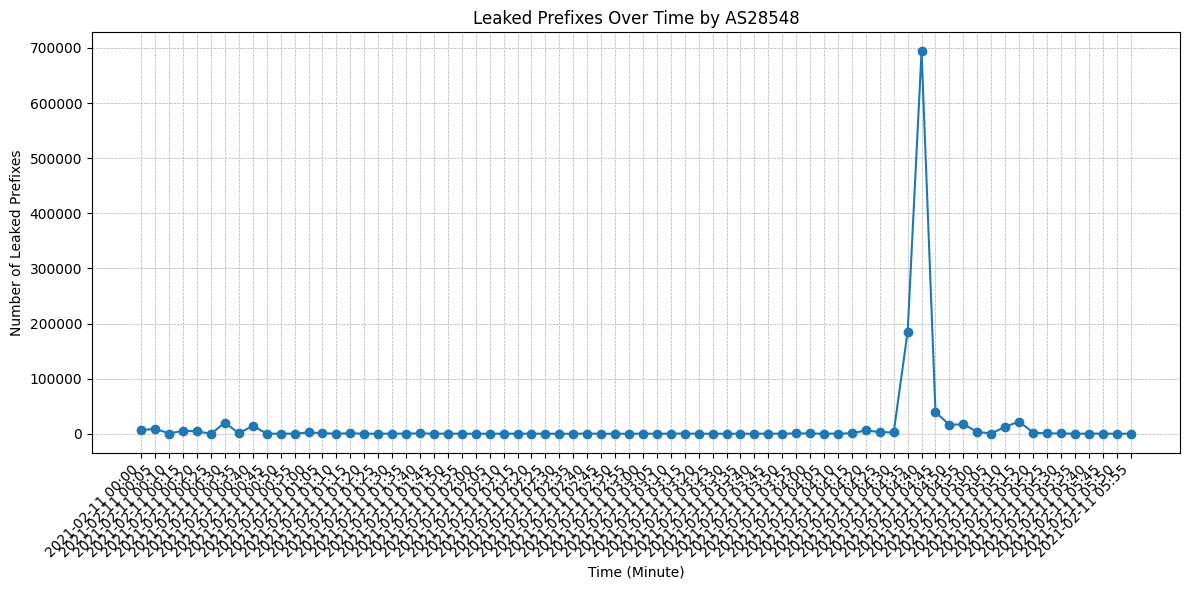

In [3]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-02-11 00:00:00 UTC"
end_time = "2021-02-11 05:59:59 UTC"

# Target ASN that propagated the leaks
leaking_asn = "28548"

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    record_type="updates"
)

# Store counts of leaked prefixes over time
leaked_prefixes_over_time = defaultdict(int)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            as_path = elem.fields["as-path"].split()
            prefix = elem.fields["prefix"]
            if leaking_asn in as_path:
                # Adjusting timestamp to 5-minute intervals
                timestamp = datetime.utcfromtimestamp(rec.time)
                timestamp_minute = timestamp.replace(minute=timestamp.minute - timestamp.minute % 5).strftime('%Y-%m-%d %H:%M')
                leaked_prefixes_over_time[timestamp_minute] += 1

# Visualizing the spike in leaked prefixes over time
timestamps = sorted(leaked_prefixes_over_time.keys())
counts = [leaked_prefixes_over_time[ts] for ts in timestamps]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker='o', linestyle='-')

# Threshold for flagging
threshold = 2000

# Check and print flags for significant leak events
for ts, count in leaked_prefixes_over_time.items():
    if count > threshold:
        print(f"Significant leak event at {ts} with {count} leaked prefixes")

plt.xlabel('Time (Minute)')
plt.ylabel('Number of Leaked Prefixes')
plt.title(f'Leaked Prefixes Over Time by AS{leaking_asn}')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


# April 2021: Large BGP routing leak out of India - Can't find the records

In [9]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window around the incident
start_time = "2021-04-16 13:00:00 UTC"
end_time = "2021-04-16 15:59:59 UTC"

# AS55410 (Vodafone Idea Ltd.)
hijacking_asn = "55410"

# Initialize BGPStream with collectors that have good visibility in India
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["rrc00"],
    record_type="updates"
)

# Store unique prefixes announced by AS55410
prefix_announcements = defaultdict(set)

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            as_path = elem.fields["as-path"].split()
            prefix = elem.fields["prefix"]
            # Check if AS55410 is the originator of the prefix
            if as_path[0] == hijacking_asn:
                timestamp_minute = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
                prefix_announcements[timestamp_minute].add(prefix)

# Count the number of unique prefixes announced per minute
prefix_count_per_minute = {minute: len(prefixes) for minute, prefixes in prefix_announcements.items()}

# Visualizing the spikes in prefix announcements over time
timestamps = sorted(prefix_count_per_minute.keys())
counts = [prefix_count_per_minute[ts] for ts in timestamps]

plt.figure(figsize=(12, 6))
plt.plot(timestamps, counts, marker='o', linestyle='-')
plt.xlabel('Time (Minute)')
plt.ylabel('Number of Unique Prefixes Announced')
plt.title('Spikes in Prefix Announcements by AS55410')
plt.xticks(rotation=45, ha='right')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# February 2022: Attackers hijacked BGP prefixes that belonged to a South Korean cryptocurrency platform
and then issued a certificate on the domain via ZeroSSL to serve a malicious JavaScript file, stealing $1.9 million worth of cryptocurrency.

1701391398 HTTP ERROR: Failure when receiving data from the peer (56)
1701391513 HTTP ERROR: Failure when receiving data from the peer (56)


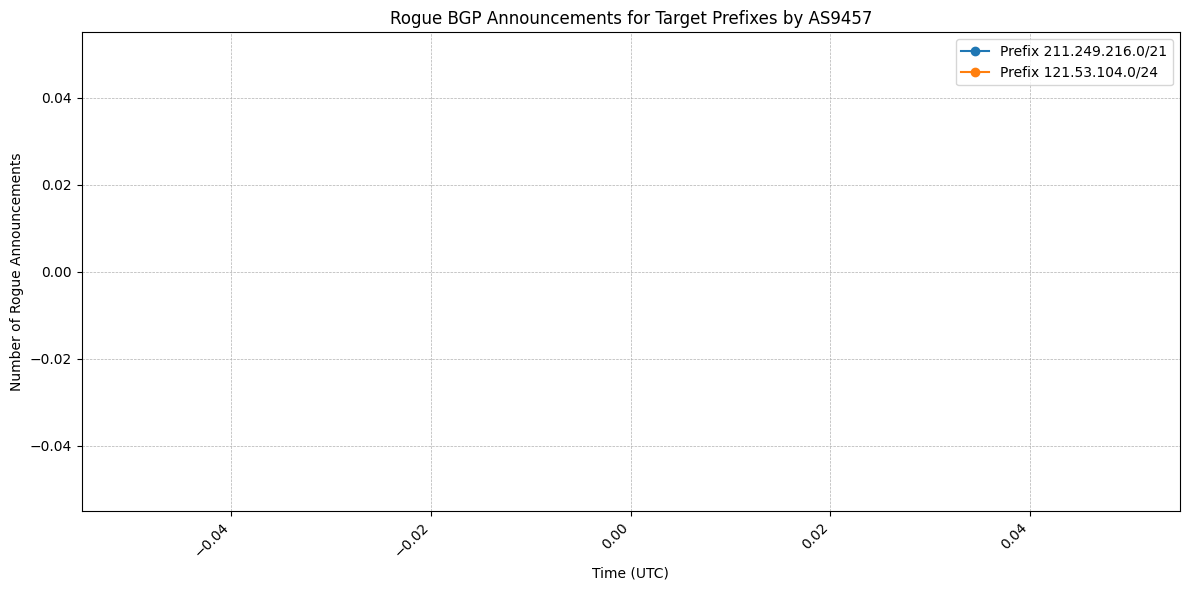

In [1]:
import pybgpstream
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict

# Define the time window of the incident
start_time = "2023-02-03 00:00:00 UTC"
end_time = "2023-02-03 23:59:59 UTC"

# Target prefixes and rogue ASN
target_prefixes = ["211.249.216.0/21", "121.53.104.0/24"]
rogue_asn = "9457"

# Initialize BGPStream
stream = pybgpstream.BGPStream(
    from_time=start_time,
    until_time=end_time,
    collectors=["rrc00"],
    record_type="updates"
)

# Store counts of relevant BGP announcements over time for each prefix
announcement_counts = {prefix: defaultdict(int) for prefix in target_prefixes}

# Process BGP records
for rec in stream.records():
    for elem in rec:
        if elem.type == "A":
            prefix = elem.fields["prefix"]
            as_path = elem.fields["as-path"].split()
            # Check for the presence of the rogue ASN and target prefixes in the AS path
            if any(prefix.startswith(target_prefix) for target_prefix in target_prefixes) and rogue_asn in as_path:
                timestamp_minute = datetime.utcfromtimestamp(rec.time).strftime('%Y-%m-%d %H:%M')
                announcement_counts[prefix][timestamp_minute] += 1

# Visualizing the rogue announcements over time for each prefix
plt.figure(figsize=(12, 6))

for prefix in target_prefixes:
    timestamps = sorted(announcement_counts[prefix].keys())
    counts = [announcement_counts[prefix][ts] for ts in timestamps]
    plt.plot(timestamps, counts, marker='o', linestyle='-', label=f'Prefix {prefix}')

plt.xlabel('Time (UTC)')
plt.ylabel('Number of Rogue Announcements')
plt.title(f'Rogue BGP Announcements for Target Prefixes by AS{rogue_asn}')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
